In [87]:
%matplotlib inline
# It is better to view the results in separate windows so that you
# can zoom in more comfortably. If an error pops up that no qt bindings
# can be found, install the package pyqt5 by the command
#   pip install pyqt5
# If everything fails change to %matplotlib (without qt) or %matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

# some functions which will be helpful:

def plot_spectrum(spc, wintitle):
    plt.figure(wintitle)
    plt.clf()
    center_x, center_y = np.round(spc.shape[1]/2), np.round(spc.shape[0]/2)
    plt.plot([0, spc.shape[1]], [center_y, center_y], 'r--', linewidth=0.5)
    plt.plot([center_x, center_x], [0, spc.shape[0]], 'r--', linewidth=0.5)
    plt.imshow(spc)
    plt.show()
    
def plot_img(img, wintitle, **kwargs):
    plt.figure(wintitle)
    plt.clf()
    plt.imshow(img, **kwargs)
    plt.show()

def ringmask(r_in, r_out, nrows, ncols):
    '''Generates an array of size nrows x ncols containing a ring with inner radius r_in 
    and outer radius r_out'''
    x = np.linspace(-ncols/2, ncols/2, num=ncols)
    y = np.linspace(-nrows/2, nrows/2, num=nrows)
    X, Y = np.meshgrid(x, y)
    d = X**2 + Y**2
    return np.logical_and(d >= r_in**2, d <= r_out**2).astype(np.uint8)

---
#### P2a: The 2D Fourier Transform

---
<div class="alert alert-info">
<p>
University of Applied Sciences Munich<br>
Dept of Electrical Enineering and Information Technology<br>
Institute for Applications of Machine Learning and Intelligent Systems (IAMLIS)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;(c) Alfred Schöttl 2023<br>
</p>
</div>

In this notebook, we will investigate the Fourier transform of images.

We have prepared several images for you so that you can investigate some properties of the Fourier transform. Let's start with the first (namely `fns[0]`) and try out all of them.

In [88]:
fns = ['stripes1', 'stripes2', 'stripes3', 'stripes4', 'stripes5', 'disk1', 'disk2', 'ground1gray', 'ground2gray', 
       'meshgray', 'pattern']

In [89]:
fn = '../imgs/' + fns[5] + '.jpg'

### 1. Read in the image and rescale it to 0..1
Read in the image named fn as grayscale image and rescale it to float with values in 0..1. Use the function plot_img defined above to display the image. The function takes the image, the title of the plot and options (if needed, such as cmap='gray') as input. Print the shape of the image to ensure that it does not contain any color channels (only two numbers, height and width, shall be printed out).

_Remark_: Since we will need to magnify the plots and look at singular pixels, it is more convenient not to include the plots in the notebook. We will open separate windows for each plot (just as we would have done from an ordinary Python program). 

(640, 640)


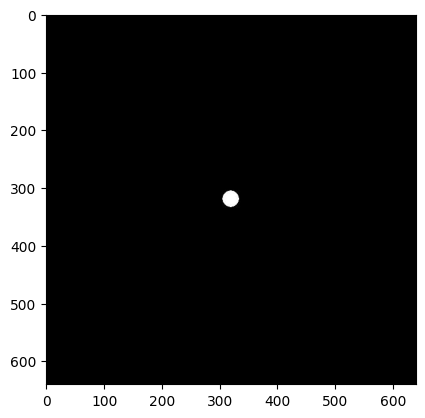

In [90]:
img = cv2.imread(fn, cv2.IMREAD_GRAYSCALE) / 255.0
print(img.shape)
plt.imshow(img, cmap='gray')

### 2. Perform the Fourier transform
Apply the following operations:  
- OpenCV knows the function `cv2.dft(img, flags=cv2.DFT_COMPLEX_OUTPUT)` which performs a Fourier transform. The output is an image of the same size as the original image with two channels. The first channel contains the real and the second the imaginary part of the Fourier coefficients. Save the result of the Fourier transform in `ft`.
- The classical Fourier transform defines the origin (the zero frequencies in both directions) at (0,0) on the top left corner. It is more convenient in image processing to shift the origin in the middle of the plot. The shift is performed by `np.fft.fftshift(...)`, save the result in `ft_shifted`.
- It is more convenient to consider the magnitude (and the phase) of the transform. Apply `cv2.cartToPolar(ft_shifted[:,:,0], ft_shifted[:,:,1])` to our transform. The result consists of two images which we will call `mag` and `phase`.
- Details in the magnitude are better visible if we logarithmize `mag`. Save the result in `logmag`.
- Plot the logarithm of the magnitude by the prepared function `plot_spectrum`. The arguments are the same as for `plot img`. Zoom in and investigate the singular pixels, especially in the area around the zero frequencies.

_Hint_: Add a very small constant to `mag` to avoid evaluating the logarithm of zero magnitudes. 

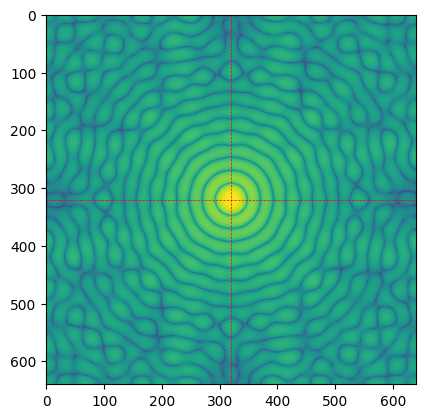

In [91]:
ft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shifted = np.fft.fftshift(ft)
mag, phase = cv2.cartToPolar(dft_shifted[:,:,0], dft_shifted[:,:,1])
logmag = np.log(mag)
plot_spectrum(logmag, 'log magnitude')

### 3. Perform the inverse transform
The steps we have just executed can be reverted. There will be some quality degradation however due to numerical issues. We start with the magnitude `mag` and the `phase` of a Fourier transform.
- `cv2.polarToCart(mag, phase)` converts the imaginary data in polar representation into real/imaginary representation. The result is a pair of images holding the real and the imaginary part (call it `real`, `imag`).
- Combine these two images to one image with two channels by the numpy-command `np.stack([real, imag], axis=2)`.  If you are not sure what this means, print the shape of the two input images and of the output image and interpret the printout. Save the result in `dft_mod_shifted`.
- We can revert the shift of the origin by `np.fft.ifftshift(...)`, save the result in `dft_mod`.
- Perform the inverse Fourier transform by `cv2.idft(..., flags=cv2.DFT_COMPLEX_OUTPUT)`. The imaginary part of the result should be (nearly) zero since the input was symmetrical. Our resulting image should therefore be readily available in the zeroth channel of the output.
- Plot the reconstructed image by `plot_img`.

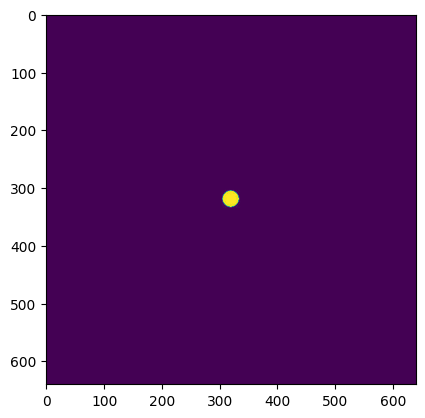

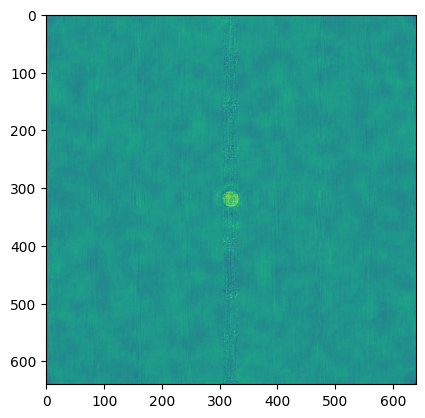

In [92]:
real, imag = cv2.polarToCart(mag, phase)  
dft_mod_shifted = np.stack([real, imag], axis=2)
dft_mod = np.fft.ifftshift(dft_mod_shifted)
rev_img = cv2.idft(dft_mod, flags=cv2.DFT_COMPLEX_OUTPUT)
plot_img(rev_img[:,:,0], 'reconstructed image')
plot_img(rev_img[:,:,1], 'reconstructed image')

### 4. Modify the magnitude
It does not make sense to transform forth and back without analysis or modification in the frequency space. As an example, let us apply a ring mask to the magnitude. A _mask_ is a matrix of the same shape as an image containing values 0 and 1. _Masking_ zeros out all pixels of another image where the mask is zero.
- Use the already defined function `ringmask(r_in, r_out, img.shape[0], img.shape[1])` to create a mask of size `img.shape` with a centered ring of inner radius `r_in` and outer radius `r_out`. (Try out different radii.)
- Plot the mask to check if the ring was created successfully.
- Apply the mask to the magnitude `mag` and save the result in `masked_mag`.
- Perform the reconstruction with the masked magnitude and the original phase as in section 3.

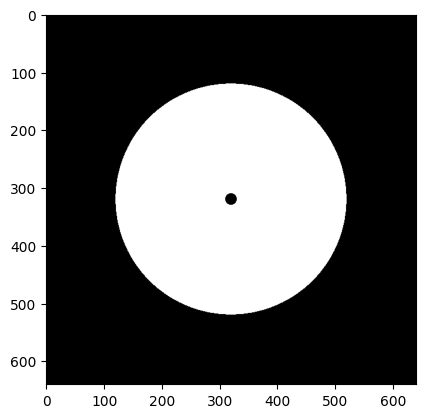

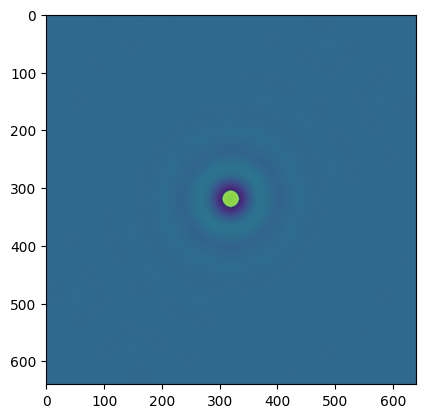

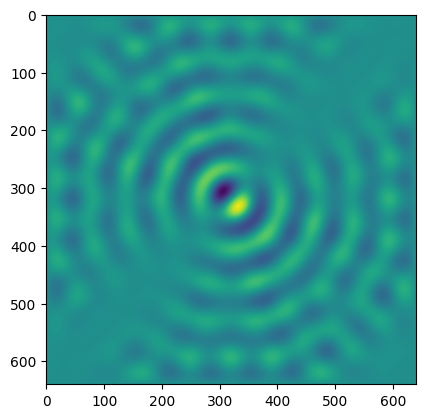

In [93]:
mask = ringmask(10, 200, img.shape[0], img.shape[1])
plt.imshow(mask, cmap='gray')
masked_mag = mag * mask
real, imag = cv2.polarToCart(masked_mag, phase)  
dft_mod_shifted = np.stack([real, imag], axis=2)
dft_mod = np.fft.ifftshift(dft_mod_shifted)
rev_img = cv2.idft(dft_mod, flags=cv2.DFT_COMPLEX_OUTPUT)
plot_img(rev_img[:,:,0], 'reconstructed image')
plot_img(rev_img[:,:,1], 'reconstructed image')

### 5. Assignment
Use the file `fence.jpg` and try to filter out the background incl. the reflections in the water by application of a ring mask to the Fourier transformed image. Try to keep the fence structure and surface visible. (Just try, the result will not be perfect.)

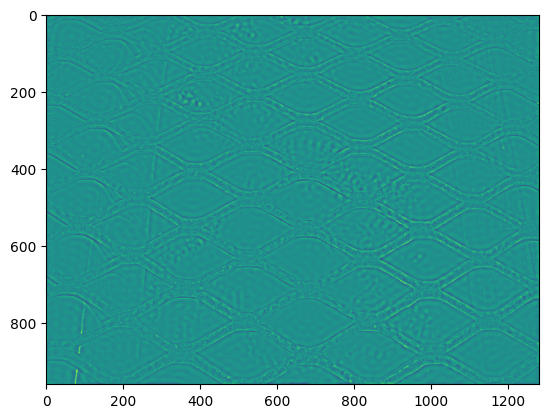

In [94]:
img = cv2.imread('../imgs/fence.jpg', cv2.IMREAD_GRAYSCALE) / 255.0
ft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shifted = np.fft.fftshift(ft)
mag, phase = cv2.cartToPolar(dft_shifted[:,:,0], dft_shifted[:,:,1])
mask = ringmask(50, 1000, img.shape[0], img.shape[1])
masked_mag = mag * mask
real, imag = cv2.polarToCart(masked_mag, phase)  
dft_mod_shifted = np.stack([real, imag], axis=2)
dft_mod = np.fft.ifftshift(dft_mod_shifted)
rev_img = cv2.idft(dft_mod, flags=cv2.DFT_COMPLEX_OUTPUT)
plot_img(rev_img[:,:,0], 'reconstructed image')